<table style="width: 100%;"> <tr> <td style="width: 20%; vertical-align: top;"> <img src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" alt="UdeA" height="150px"> </td> <td style="width: 80%; padding-left: 20px;"> <strong style="font-size: 30px;">MODELO DE REDES NEURONALES CONVOLUCIONALES PARA UN SISTEMA DE CLASIFICACIÓN CON IMÁGENES DE RESONANCIA MAGNÉTICA </strong><br><br> <span style="font-size: 30px;"> Luisa Fernanda Alzate Cuartas <br> Juan Camilo Henao Caro<br>Isabella Mendez Hoyos<br> Fernando Antonio Piñeres Ramos </span> </td> </tr> </table>

#### IMPORTE E INSTALACIÓN DE LIBRERÍAS

In [ ]:
# Conectar con Google Drive
from google.colab import drive
drive.mount('/content/drive')
import sys #Interactuar de manera directa con el intérprete de Python
import os #Se utiliza para interactuar con el sistema operativo

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/operaciones' # Configura el entorno para trabajar con archivos en Google Drive
sys.path.append(path) # Permite importar módulos desde esta ruta.
os.chdir(path) # Cambia el directorio de trabajo actual

In [ ]:
# Instalación de librerías.
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.6 MB/s eta 0:00:00


In [ ]:
# Importe de librerías.
import optuna
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import shuffle
import joblib

#### LECTURA DEL CONJUNTO DE IMÁGENES

In [ ]:
### cargar bases_procesadas ####
x_train = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_test.pkl')
x_val = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_val.pkl')
y_val = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_val.pkl')

#### ESCALADO DEL CONJUNTO DE DATOS.

In [ ]:
#### Escalar ######################
x_train=x_train.astype('float32') ## para poder escalarlo
x_test=x_test.astype('float32') ## para poder escalarlo
x_train.max()
x_train.min()


x_train /=255 ### escalarlo para que quede entre 0 y 1, con base en el valor máximo
x_test /=255

###### verificar tamaños

x_train.shape
x_test.shape

np.prod(x_train[1].shape) ## cantidad de variables por imagen

display(np.unique(y_train, return_counts=True))
display(np.unique(y_test, return_counts=True))

(array([0, 1, 2, 3]), array([1232, 1316, 1600, 1405]))

(array([0, 1, 2, 3]), array([154, 165, 200, 176]))

#### DATA AUGMENTATION

In [ ]:

# Crear el generador de augmentación
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest' #se rellena los pixeles vacios con el pixel mas cercano
)

# Función para balancear un conjunto de datos (train o test)
def balance_dataset(x, y, datagen):
    classes, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    x_aug = []
    y_aug = []

    for c in classes:
        x_class = x[y == c]
        y_class = y[y == c]
        n_samples_needed = max_count - len(x_class)

        # Agregar los datos originales
        x_aug.extend(x_class)
        y_aug.extend(y_class)

        # Generar muestras augmentadas si es necesario
        if n_samples_needed > 0:
            # Reshape para que datagen.flow funcione correctamente con un solo lote
            x_class_reshaped = np.expand_dims(x_class, axis=1)
            y_class_reshaped = np.expand_dims(y_class, axis=1)

            gen = datagen.flow(x_class, y_class, batch_size=1)
            for _ in range(n_samples_needed):
                x_gen, y_gen = next(gen)
                x_aug.append(x_gen[0])
                y_aug.append(y_gen[0])

    # Convertir a arrays numpy
    x_balanced = np.array(x_aug)
    y_balanced = np.array(y_aug)

    # Barajar (opcional pero recomendable)
    x_balanced, y_balanced = shuffle(x_balanced, y_balanced, random_state=42)

    return x_balanced, y_balanced

# Aumentar el conjunto de entrenamiento
x_train_balanced, y_train_balanced = balance_dataset(x_train, y_train, datagen)

# Aumentar el conjunto de prueba
x_test_balanced, y_test_balanced = balance_dataset(x_test, y_test, datagen)

# Guardar los conjuntos balanceados si deseas
joblib.dump(x_train_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/x_train_balanced.pkl')
joblib.dump(y_train_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/y_train_balanced.pkl')
joblib.dump(x_test_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/x_test_balanced.pkl')
joblib.dump(y_test_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/y_test_balanced.pkl')

# Verificar las distribuciones después del balanceo
display(np.unique(y_train_balanced, return_counts=True))
display(np.unique(y_test_balanced, return_counts=True))

(array([0, 1, 2, 3]), array([1600, 1600, 1600, 1600]))

(array([0, 1, 2, 3]), array([200, 200, 200, 200]))

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_balanced = to_categorical(y_train_balanced, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [ ]:
y_train_balanced.shape

(6400, 4)

#### MODELO DE REDES NEURONALES CONVOLUSIONALES.

In [ ]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=x_train_balanced.shape[1:]),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model with binary cross-entropy loss and Adam optimizer
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])

cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,654,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,659,620 (10.15 MB)

 Trainable params: 2,659,620 (10.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## checkpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_AUC',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1
)


In [ ]:
#Entrenar modelo para 10 epochs
history = cnn_model.fit(x_train_balanced, y_train_balanced, batch_size=100, epochs=3, validation_data=(x_test, y_test), callbacks=[checkpoint])





Epoch 1/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.7088 - loss: 1.2613
Epoch 1: val_AUC improved from -inf to 0.96657, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - AUC: 0.7110 - loss: 1.2562 - val_AUC: 0.9666 - val_loss: 0.4507
Epoch 2/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9610 - loss: 0.4722
Epoch 2: val_AUC improved from 0.96657 to 0.97918, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - AUC: 0.9611 - loss: 0.4718 - val_AUC: 0.9792 - val_loss: 0.3489
Epoch 3/3
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9830 - loss: 0.3172
Epoch 3: val_AUC improved from 0.97918 to 0.98315, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - AUC: 0.9830 - loss: 0.3171 - val_AUC: 0.9831 - val_loss: 0.3005


In [ ]:
import matplotlib.pyplot as plt

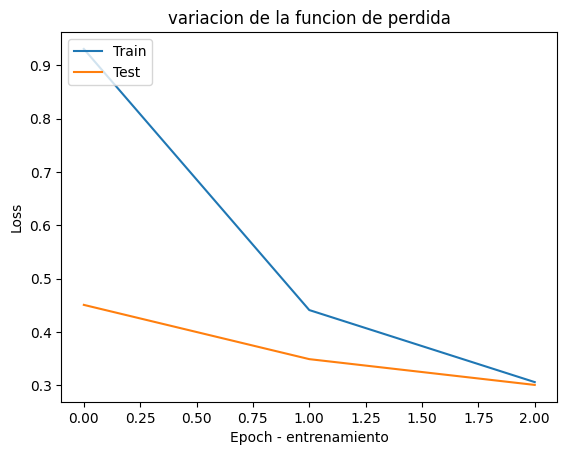

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('variacion de la funcion de perdida')
plt.ylabel('Loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

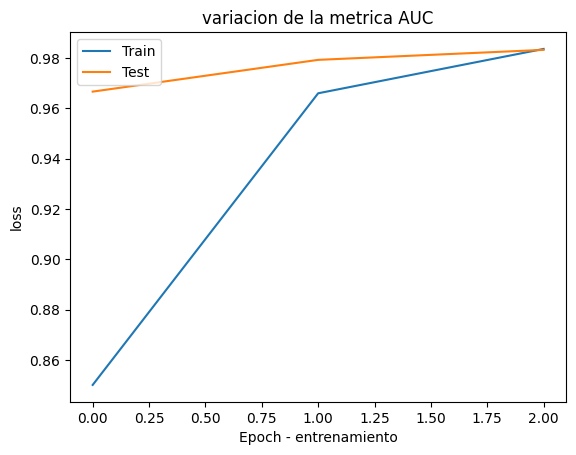

In [ ]:
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('variacion de la metrica AUC')
plt.ylabel('loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#######probar una red con regulzarización L2
reg_strength = 0.001

###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.1


cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=x_train_balanced.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model with binary cross-entropy loss and Adam optimizer
cnn_model2.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=[tf.keras.metrics.AUC(name='auc')])

checkpoint2 = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_AUC',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1
)


# Train the model for 10 epochs
history2 = cnn_model2.fit(x_train_balanced, y_train_balanced, batch_size=100, epochs=2, validation_data=(x_test, y_test), callbacks=checkpoint2)

Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - auc: 0.6460 - loss: 1.6410 - val_auc: 0.9343 - val_loss: 0.7359
Epoch 2/2


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_AUC available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - auc: 0.9210 - loss: 0.7885 - val_auc: 0.9577 - val_loss: 0.6039


In [ ]:
cnn_model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,654,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,978,862 (30.44 MB)

 Trainable params: 2,659,620 (10.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,319,242 (20.29 MB)

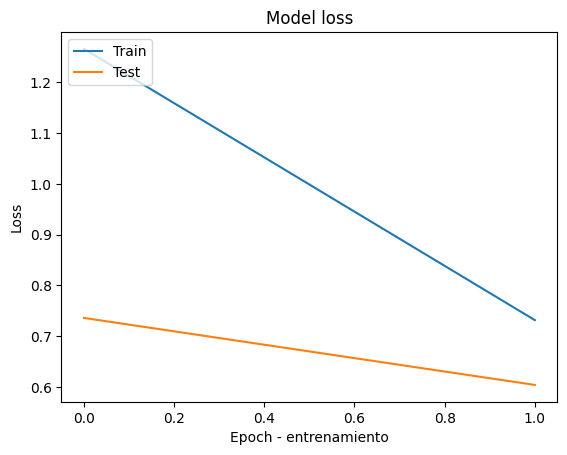

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
# Función objetivo para utilizar optuna
def objective(trial):
    # grilla de huiperparámetros
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.2, step=0.05)
    reg_strength = trial.suggest_float('reg_strength', 0.0001, 0.0005, step=0.0001)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])

    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=x_train_balanced.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    checkpoint3 = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_auc',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1)



    # Choose optimizer
    if optimizer_name == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=0.001)

    # Compile with AUC metric
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=[tf.keras.metrics.AUC(name='auc')])

    # Train the model
    model.fit(
        x_train_balanced, y_train_balanced,
        epochs=3,
        validation_data=(x_test, y_test),
        batch_size=100,
        verbose=0,
        callbacks=checkpoint3
    )

    model_win=tf.keras.models.load_model('best_model.h5')

    # Predict probabilities and compute AUC manually
    y_pred_prob = model_win.predict(x_test)
    auc = roc_auc_score(y_test, y_pred_prob)

    # Save best model in trial attributes
    trial.set_user_attr("model", model_win)

    return auc

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)

# Get best model
best_trial = study.best_trial
best_model = best_trial.user_attrs["model"]

# Final evaluation
test_loss, test_auc = best_model.evaluate(x_test, y_test)
print(f"\Mejor AUC on test set: {test_auc:.4f}")
best_model.summary()

[I 2025-06-04 12:56:54,044] A new study created in memory with name: no-name-fb0c7fee-cb46-4f27-8826-f8f5238aaa3d



Epoch 1: val_auc improved from -inf to 0.94783, saving model to best_model.h5



Epoch 2: val_auc improved from 0.94783 to 0.96338, saving model to best_model.h5



Epoch 3: val_auc improved from 0.96338 to 0.97366, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
[I 2025-06-04 13:04:14,939] Trial 0 finished with value: 0.9690525235262804 and parameters: {'dropout_rate': 0.05, 'reg_strength': 0.0001, 'optimizer': 'adam'}. Best is trial 0 with value: 0.9690525235262804.


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - auc: 0.9706 - loss: 0.4259
\Mejor AUC on test set: 0.9737


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     2,654,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,978,862 (30.44 MB)

 Trainable params: 2,659,620 (10.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,319,242 (20.29 MB)